# Fine Clustering

Clustering genes into sets based on expression patterns.

In [1]:
library(Seurat)
library(dplyr)
library(ggplot2)
library(patchwork)
library(Matrix)
library(DESeq2)
library(ClusterR)
library(scales)
library(reshape2)
library(gprofiler2)
library(scattermore)


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


Loading required package: S4Vectors

Loading required package: stats4

Loading required package: BiocGenerics

Loading required package: parallel


Attaching package: ‘BiocGenerics’


The following objects are masked from ‘package:parallel’:

    clusterApply, clusterApplyLB, clusterCall, clusterEvalQ,
    clusterExport, clusterMap, parApply, parCapply, parLapply,
    parLapplyLB, parRapply, parSapply, parSapplyLB


The following object is masked from ‘package:Matrix’:

    which


The following objects are masked from ‘package:dplyr’:

    combine, intersect, setdiff, union


The following objects are masked from ‘package:stats’:

    IQR, mad, sd, var, xtabs


The following objects are masked from ‘package:base’:

    anyDuplicated, append, as.data.frame, basename, cbind, colnames,
    

## Load Data

In [2]:
# saved Seurat session
rna = readRDS("./sessions/20210725_n59378/seurat.rds")

## Clustering

In [3]:
# get raw counts matrix
rna_subset_raw = rna@assays$RNA@counts
rna_subset_raw = Matrix::t(rna_subset_raw)
dim(rna_subset_raw)

[1] 59378 29165

In [4]:
clusters = as.numeric(rna@meta.data$RNA_snn_res.1)
agg_matrix = sparseMatrix(i=clusters,
                         j=seq(1,nrow(rna_subset_raw)),
                         x=1L,
                         dims=c(length(table(clusters)), nrow(rna_subset_raw)))

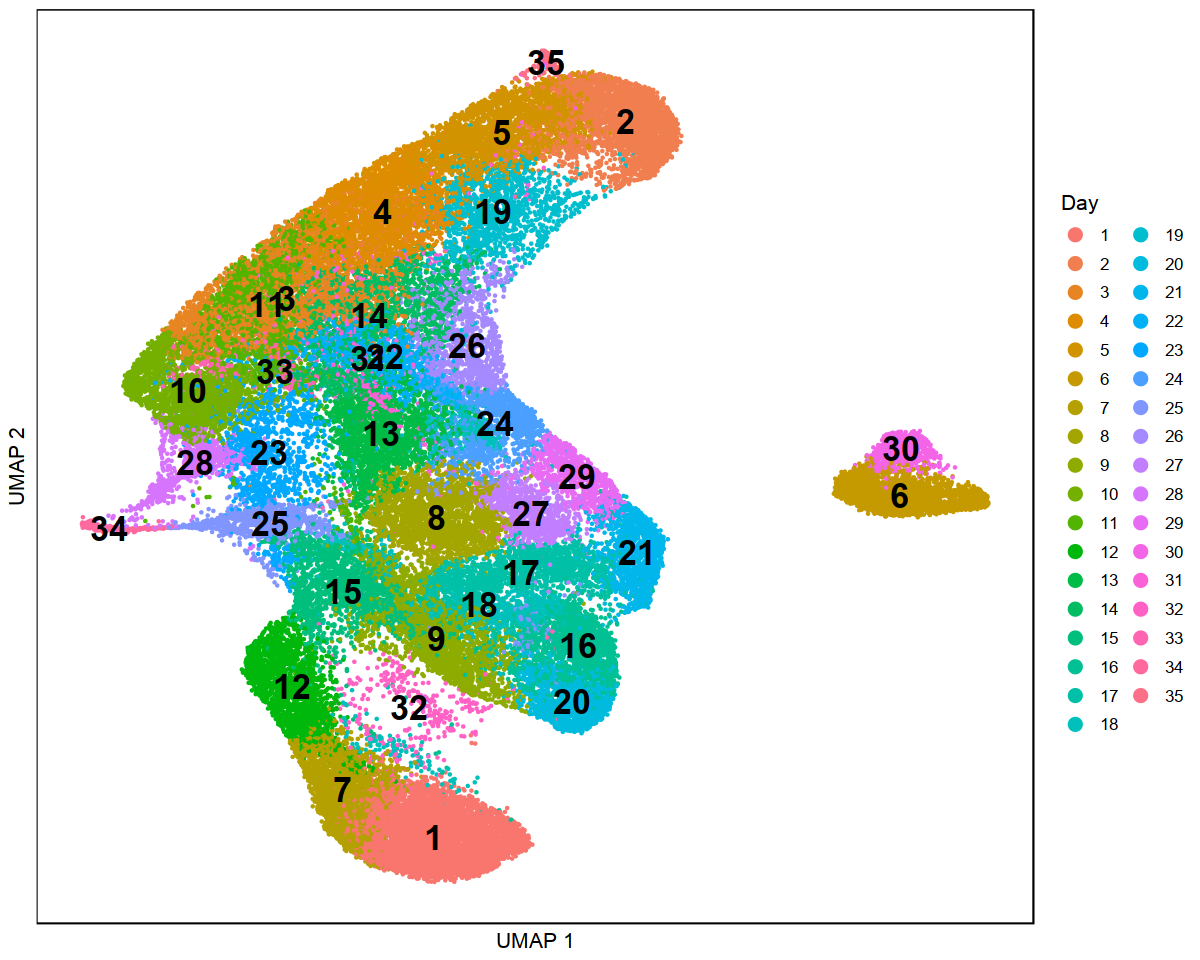

In [5]:
options(repr.plot.width = 10, repr.plot.height = 8)

plot_df <- data.frame(umap1=data.frame(Embeddings(rna, reduction='umap'))$UMAP_1,
                 umap2=data.frame(Embeddings(rna, reduction='umap'))$UMAP_2,
                 cluster=factor(clusters))
plot_df = plot_df[sample(dim(plot_df)[1]), ]

ggplot(plot_df) +
geom_point(aes(x=umap1, y=umap2, color=cluster), stroke=0, size=1) +
geom_text(data=data.frame(aggregate(plot_df[,c("umap1","umap2")], 
                            list(plot_df$cluster), median)),
         aes(x=umap1, y=umap2, label=Group.1), fontface = "bold", size=7) +
theme_classic() +
xlab("UMAP 1") + ylab("UMAP 2") +
theme(plot.title = element_text(hjust = 0.5),
      text = element_text(size=12),
      axis.line=element_blank(),
      axis.text.x=element_blank(),
      axis.text.y=element_blank(),
      axis.ticks=element_blank(),
      panel.border = element_rect(colour = "black", fill=NA, size=0.5)) +
guides(colour = guide_legend(title="Day",
     override.aes = list(shape=16, alpha=1, size=4)))

In [6]:
cts = as.matrix(agg_matrix %*% rna_subset_raw)
colnames(cts) = rownames(rna)
rownames(cts) = paste("cluster", seq(1,nrow(cts)), sep="_")
cts = t(cts)
head(cts)
dim(cts)

cluster_1 cluster_2 cluster_3 cluster_4 cluster_5 cluster_6
OR4F5       0         0         0         0         0         0       
AL627309.1 10         8        17        13        16         9       
AL627309.5 37        68        37        32        68        67       
AL627309.4  0         0         0         0         0         7       
AP006222.2  0         1         0         0         0         0       
AL669831.2  0         0         0         0         0         5       
           cluster_7 cluster_8 cluster_9 cluster_10 ⋯ cluster_26 cluster_27
OR4F5       0         0         0         0         ⋯  0         0         
AL627309.1  3         1         4         1         ⋯  0         0         
AL627309.5 13        12        12        18         ⋯ 17         5         
AL627309.4  0         0         0         0         ⋯  0         0         
AP006222.2  0         0         0         0         ⋯  1         0         
AL669831.2  0         0         0         0         ⋯  0         0         
           cluster_28 cluster_29 cluster_30 cluster_31 cluster_32 cluster_33
OR4F5       1          0          0         0          0          0         
AL627309.1  5          1          0         2          0          0         
AL627309.5 12         14         11         2          5          2         
AL627309.4  0          0          4         0          0          0         
AP006222.2  0          0          0         0          0          0         
AL669831.2  0          0          4         0          0          0         
           cluster_34 cluster_35
OR4F5      0          0         
AL627309.1 2          1         
AL627309.5 1          5         
AL627309.4 0          0         
AP006222.2 0          0         
AL669831.2 0          0

[1] 29165    35

In [7]:
quantile(rowSums(cts), c(0, 0.02, 0.05,  0.1, 0.25, 0.5, 0.75, 0.9, 0.99, 1))

0%         2%         5%        10%        25%        50%        75% 
       0.0        2.0        3.0        6.0       35.0      741.0    12846.0 
       90%        99%       100% 
   44560.6   441511.2 14578008.0

In [8]:
cts = cts[rowSums(cts)>50, ]
dim(cts)

[1] 20993    35

In [9]:
norm_cts = t(t(cts)/estimateSizeFactorsForMatrix(cts))

In [10]:
topk_var_genes = VariableFeatures(FindVariableFeatures(rna, selection.method = "vst", nfeatures = 5000))

In [11]:
"BCL2A1" %in% topk_var_genes

[1] TRUE

In [12]:
norm_cts = norm_cts[rownames(norm_cts) %in% topk_var_genes, ]
dim(norm_cts)

[1] 4306   35

In [13]:
log_norm_cts = log2(1+norm_cts)

In [332]:
cts_to_cluster = log_norm_cts 

# z norm
cts_to_cluster = t(scale(t(cts_to_cluster)))

# append z norm
# znormed = t(scale(t(cts_to_cluster)))
# colnames(znormed) = paste(colnames(znormed), "znorm", sep='_')
# cts_to_cluster = cbind(cts_to_cluster, znormed)

In [333]:
# ADD RAND SEED - not required
NUM_PEAK_SETS = 15
km_mb = MiniBatchKmeans(cts_to_cluster, 
                        batch_size = 1000,
                        clusters = NUM_PEAK_SETS,
                        num_init = 50, 
                        verbose = FALSE)

In [334]:
pr_mb = predict_MBatchKMeans(cts_to_cluster, km_mb$centroids)

In [335]:
sort(table(pr_mb))

pr_mb
 13   5  11   2  12   7   4   6   1   8  15  14  10   9   3 
165 192 205 218 225 228 250 259 303 309 327 370 387 428 440 

In [338]:
cts_clustered = cts_to_cluster[order(pr_mb), 1:length(unique(clusters))] # divide when znormed pasted
head(cts_clustered, 2)

cluster_1  cluster_2  cluster_3  cluster_4  cluster_5  cluster_6 
RNF223 -0.6227589 -0.6227589  0.3613740 -0.2028753 -0.1443040 -0.6227589
SCNN1D  0.5024423 -0.7010622 -0.3459255 -0.8600636 -0.4092073 -0.5709081
       cluster_7  cluster_8  cluster_9   cluster_10 ⋯ cluster_26 cluster_27 
RNF223 -0.6227589 -0.6227589 -0.14863628  0.2129087 ⋯  0.8452778 -0.62275888
SCNN1D  0.3200033 -1.0684122  0.01197478 -0.2122686 ⋯ -0.1955185  0.09478199
       cluster_28 cluster_29  cluster_30  cluster_31 cluster_32 cluster_33
RNF223 0.9580478   0.02884914 -0.62275888  0.1064746 -0.6227589  2.4321830
SCNN1D 0.6829689  -0.02544754  0.04862155 -1.0960261  0.5115263 -0.6438918
       cluster_34 cluster_35 
RNF223 4.476270   -0.62275888
SCNN1D 5.151947   -0.02686782

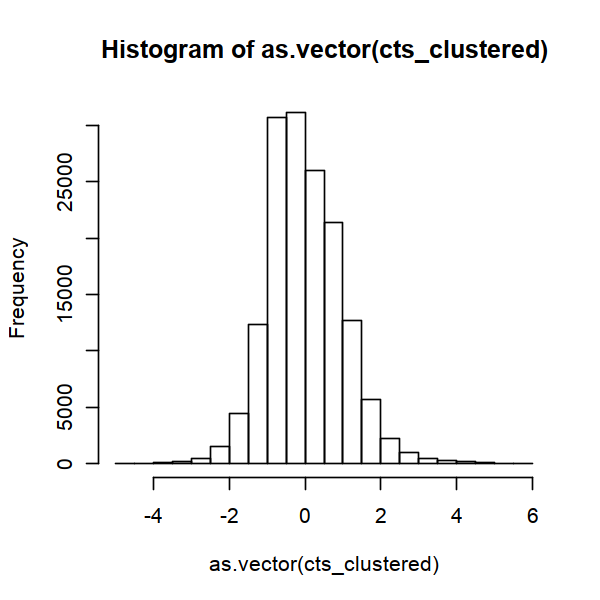

In [339]:
options(repr.plot.width = 5, repr.plot.height = 5)
hist(as.vector(cts_clustered))

In [340]:
sample(rownames(cts_to_cluster)[(which(pr_mb==4))], 10)

[1] "TMEM132B"  "GAD1"      "TCEAL2"    "FEZF1-AS1" "NTRK3"     "SULT2B1"  
 [7] "SNRPN"     "IGSF21"    "FGF23"     "RSPO4"

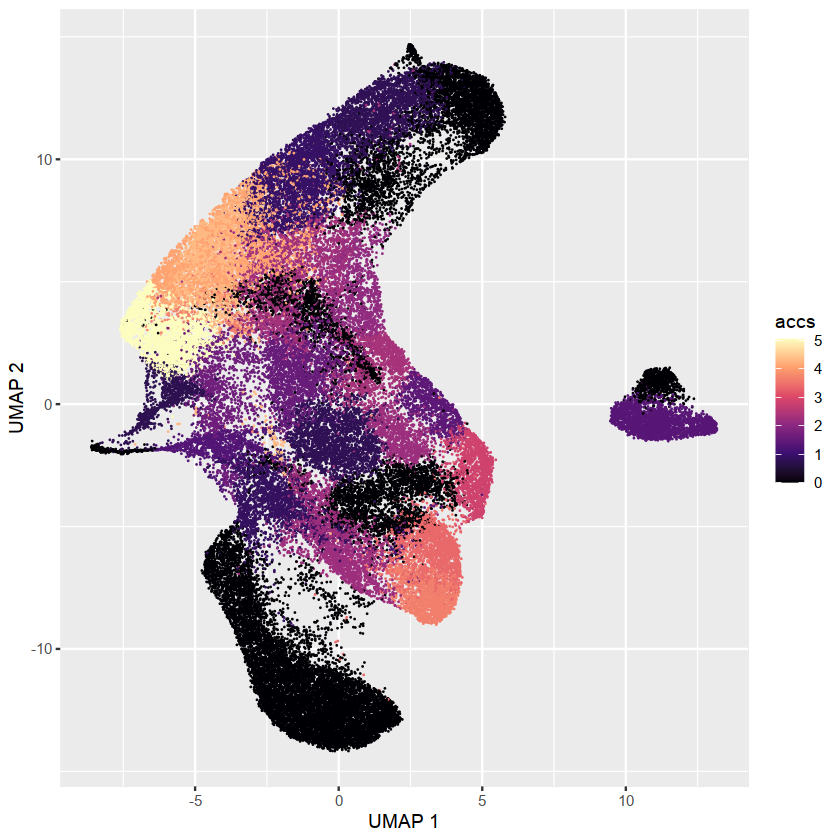

In [53]:
options(repr.plot.width = 7, repr.plot.height = 7)

# visualize a centroid
# df = data.frame(x.sp@umap, accs=km_mb$centroids[selected_cluster_id, ][clusters])

# or a specific peak
df = data.frame(umap1=data.frame(Embeddings(rna, reduction='umap'))$UMAP_1, 
                umap2=data.frame(Embeddings(rna, reduction='umap'))$UMAP_2, 
                accs=log2(norm_cts["PTGDR", ][clusters]+1))

# shuffle so days don't overlap
df = df[sample(dim(df)[1]), ]

ggplot(df) +
# ggplot(df[df$x.sp.sample %in% c("D14"), ]) +
geom_point(size=0.5, stroke = 0,alpha=1, aes(x=umap1 , y=umap2, col=accs)) +
xlab("UMAP 1") + ylab("UMAP 2") +
scale_color_viridis_c(#limits=c(0, 6),
                      oob=squish, option = "A") +
theme(plot.title = element_text(hjust = 0.5))

In [321]:
gene_lists = list()
for (i in seq(length(table(pr_mb)))) {
    gene_lists[[i]] = rownames(cts_to_cluster)[(which(pr_mb==i))]
}

In [322]:
# manual reordering 
# gene_lists = gene_lists[c(2,9,11,13,6,1,12,5,14,3,8,10, 4, 15,7)]

In [142]:
# plots = list()
# for (i in seq(1,NUM_PEAK_SETS)) {
#     df = data.frame(umap1=data.frame(Embeddings(rna, reduction='umap'))$UMAP_1, 
#                     umap2=data.frame(Embeddings(rna, reduction='umap'))$UMAP_2, 
#                     znorm_expr=km_mb$centroids[i, ][clusters])
#     # shuffle so days don't overlap
#     df = df[sample(dim(df)[1], 20000), ]
    
#     plots[[i]] <- ggplot(df) +
#     # ggplot(df[df$x.sp.sample %in% c("D14"), ]) +
#     geom_point(size=0.8, stroke = 0, alpha=1, aes(x=umap1 , y=umap2, col=znorm_expr)) +
#     ggtitle(sprintf("Cluster %d (%d)", i, length(gene_lists[[i]]))) + 
#     xlab("UMAP 1") + ylab("UMAP 2") +
#     scale_color_viridis_c(limits=c(-2,2), oob=squish, option = "A") +
#     theme_classic() +
#     theme(plot.title = element_text(hjust = 0.5),
#          legend.position = "none",
#          axis.ticks = element_blank(),
#          axis.text =element_blank(),
#          axis.line=element_blank(),
#          panel.border = element_rect(colour = "black", fill=NA, size=0.5))
# }

In [144]:
# # get legend
# df = data.frame(umap1=data.frame(Embeddings(rna, reduction='umap'))$UMAP_1, 
#                 umap2=data.frame(Embeddings(rna, reduction='umap'))$UMAP_2,
#                 znorm_expr=km_mb$centroids[1, ][clusters])
# # shuffle so days don't overlap
# df = df[sample(dim(df)[1], 20000), ]

# cur_plot <- ggplot(df) +
# # ggplot(df[df$x.sp.sample %in% c("D14"), ]) +
# geom_point(size=1, alpha=1, aes(x=umap1 , y=umap2, col=znorm_expr)) +
# ggtitle(sprintf("Cluster %d", i)) + 
# xlab("UMAP 1") + ylab("UMAP 2") +
# scale_color_viridis_c(limits=c(-2, 2), oob=squish, option = "A") +
# theme_classic() +
# theme(plot.title = element_text(hjust = 0.5),
#      axis.ticks = element_blank(),
#      axis.text =element_blank(),
#      axis.line=element_blank(),
#      panel.border = element_rect(colour = "black", fill=NA, size=0.5))

# legend_only = cowplot::get_legend(cur_plot)

In [ ]:
# options(repr.plot.width = 20, repr.plot.height = 15)
# wrap_plots(wrap_plots(plots, ncol = 5), legend_only, widths=c(0.95,0.05))  
# ggsave(sprintf("figs/20200705_gridmap_peakwidthnorm_logplusznorm_4way_ordered_n40/log_cts.jpeg"),
#                format(Sys.Date(), format='%Y%m%d'), length(table(pr_mb))),
#        width=20, height=40, dpi=300)

In [360]:
sc_plots = list()
for (i in seq(1,NUM_PEAK_SETS)) {
    tot_counts = colMeans(rna@assays$RNA@scale.data[gene_lists[[i]], ])
    df = data.frame(umap1=data.frame(Embeddings(rna, reduction='umap'))$UMAP_1, 
                    umap2=data.frame(Embeddings(rna, reduction='umap'))$UMAP_2, 
                    norm_reads=tot_counts)
    # shuffle so days don't overlap
    df = df[sample(dim(df)[1], 20000), ]
    
    sc_plots[[i]] <- ggplot(df) +
    # ggplot(df[df$x.sp.sample %in% c("D14"), ]) +
    geom_scattermore(pointsize=10, aes(x=umap1 , y=umap2, col=norm_reads), pixels=c(3000,3000)) +
#     geom_point(size=0.8, stroke = 0, alpha=1, aes(x=umap1 , y=umap2, col=norm_reads)) +
    ggtitle(sprintf("Gene Set %d (%d)", i, length(gene_lists[[i]]))) + 
    xlab("UMAP 1") + ylab("UMAP 2") +
    scale_color_viridis_c(limits=quantile(tot_counts, c(0.01,0.99)), oob=squish, option = "A", name="Z-score") +
    theme_classic() +
    theme(plot.title = element_text(hjust = 0.5),
         axis.ticks = element_blank(),
         axis.text =element_blank(),
         axis.line=element_blank(),
         panel.border = element_rect(colour = "black", fill=NA, size=0.5))
}

In [268]:
IDX=8
gene_lists[[IDX]][grep("^COL", gene_lists[[IDX]])]

[1] "COL21A1" "COL10A1" "COL27A1"

In [178]:
which(lapply(gene_lists, function(x){"HBA2" %in% x})==T)

[1] 6

In [280]:
quantile(colMeans(rna@assays$RNA@scale.data[gene_lists[[10]], ]), c(0, .01, .9))

0%         1%        90% 
-0.4070062 -0.3266606  0.5017496

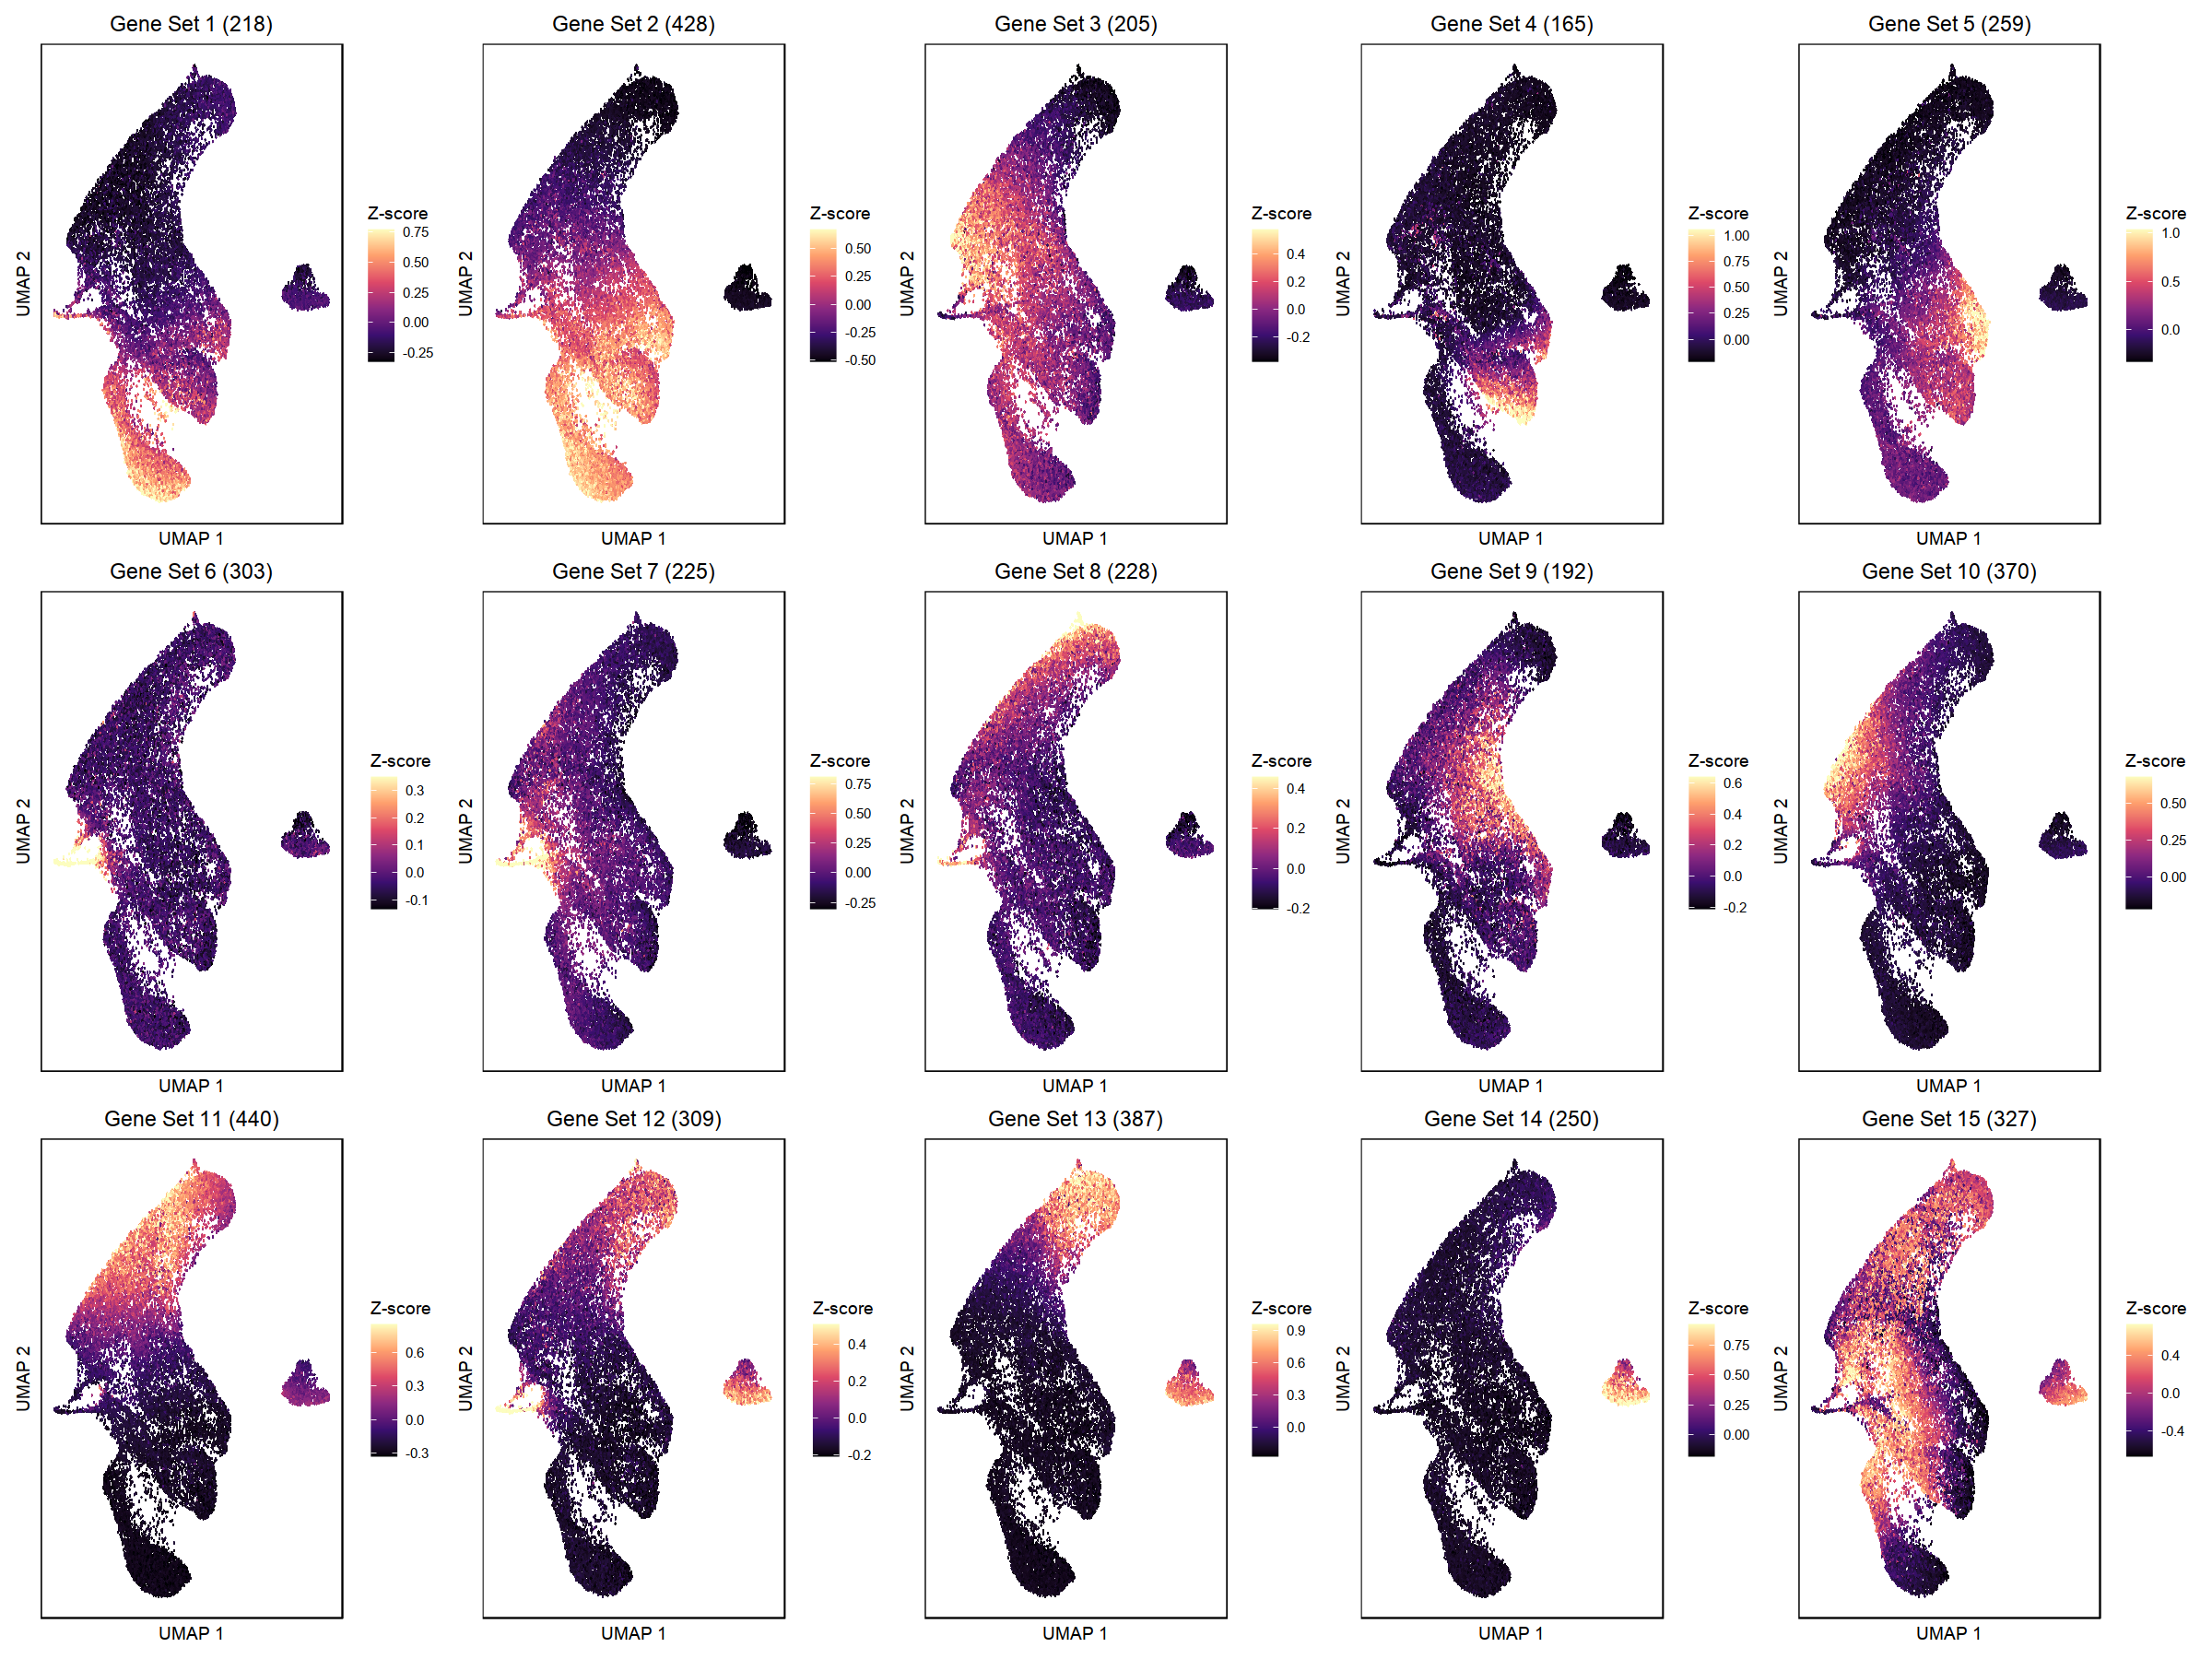

In [361]:
options(repr.plot.width = 20, repr.plot.height = 15)
sc_together = wrap_plots(sc_plots, ncol = 5)
# ggsave(sprintf("figs/20200705_gridmap_peakwidthnorm_logplusznorm_4way_ordered_n40/log_cts.jpeg"),
#                format(Sys.Date(), format='%Y%m%d'), length(table(pr_mb))),
#        width=20, height=40, dpi=300)
sc_together

In [372]:
ggsave(sc_together, file=sprintf("../../figures_factory/Fig2/subfigs/%s_gene_set_zscore_avg.pdf", format(Sys.Date(), "%Y%m%d")),
       width=20, height=15)

In [34]:
# options(repr.plot.width = 25, repr.plot.height = 10)
# wrap_plots(wrap_plots(sc_plots, ncol = 5))
# ggsave("gene_sets/20211004_tmp_gridmap_znorm_n10/sc.jpeg",
#        width=25, height=10, dpi=300)

In [170]:
CLUSTER_IDX = 1
NORM = 'znorm'
GENE_SET_PATH = sprintf("gene_sets/%s_%s_n%d/idx%d.txt", format(Sys.Date(), format='%Y%m%d'), NORM, length(table(pr_mb)), CLUSTER_IDX)
# rownames(vsd_assay_to_cluster_normalized)[(which(pr_mb==CLUSTER_IDX))]
GENE_SET_PATH

[1] "gene_sets/20211004_znorm_n15/idx1.txt"

In [289]:
for (i in seq(1,length(gene_lists))){
GENE_SET_PATH = sprintf("gene_sets/%s_%s_n%d/idx%d.txt", format(Sys.Date(), format='%Y%m%d'), NORM, length(gene_lists), i)
fileConn = file(GENE_SET_PATH)
writeLines(gene_lists[[i]], fileConn)
close(fileConn)}

## GSE62777 Comparison

In [290]:
# load bulk RNA-seq data
fpkm = read.table("/users/surag/kundajelab/scATAC-reprog/resources/GSE62777/RNAseq.FPKM.tsv", sep='\t', header=T)
fpkm$gene_id = NULL
fpkm$locus=NULL
tpm = fpkm
tpm[,2:ncol(tpm)] = 1e6*t(t(tpm[,2:ncol(tpm)])/colSums(tpm[,2:ncol(tpm)]))

# removing genes with dup names
tpm = tpm[!duplicated(tpm$gene_short_name),]
rownames(tpm) = tpm$gene_short_name
tpm$gene_short_name = NULL

tpm["GAPDH",]

hiF.T_P14 X2dd_DOX_plus X5dd_DOX_plus X8dd_DOX_plus
GAPDH 7803.64   4963.505      3908.693      3839.776     
      X10dd_DOX_plus_SSEA3_pos X14dd_DOX_plus_SSEA3_pos X20dd_DOX_plus_TRA_plus
GAPDH 3795.548                 3364.503                 3032.412               
      X24dd_TRA_pos_DOX_plus X24dd_TRA_pos_DOX_minus hIPSC.T_P10
GAPDH 3790.955               5598.224                4731.256

In [291]:
gene_plots = list()

In [292]:
for (i in seq(NUM_PEAK_SETS)) {
    # remove transcript name from gene
    # assumes gene lists are tables sorted in decreasing importance
    gene_set_to_plot = gene_lists[[i]]
    
    # filter to those that have >1 TPM at any time point
    gene_set_to_plot = gene_set_to_plot[gene_set_to_plot %in% rownames(tpm)]
    gene_set_to_plot = gene_set_to_plot[rowMaxs(as.matrix(tpm[gene_set_to_plot, ]))>1]

    # choose top
    gene_set_to_plot = gene_set_to_plot

    gene_plots[[i]] <- 
    ggplot(melt(as.matrix(log2(1+tpm)[rownames(tpm) %in% gene_set_to_plot, ])), aes(x=Var2, y=value)) +
    #     ggplot(melt(t(scale(t(log2(1+tpm)[rownames(tpm) %in% gene_set_to_plot, ])))), aes(x=Var2, y=value)) +
    stat_boxplot() +
    #     geom_line(aes(group=Var1),size=0.1) + geom_point() +
    ggtitle(sprintf("GENE SET %d", i)) +
    theme_classic() +
    theme(plot.title = element_text(hjust = 0.5),
      text = element_text(size=12),
#       axis.line=element_blank(),
      axis.text.x = element_text(angle = -45, hjust=0),
#       axis.text.y=element_blank(),
#       axis.ticks=element_blank(),
      legend.title=element_text(size=10), 
      legend.text=element_text(size=9),
      panel.border = element_rect(colour = "black", fill=NA, size=0.5)) +
    ylab("log2 TPM") + xlab("") +
    coord_cartesian(ylim=c(0,10)) 
}

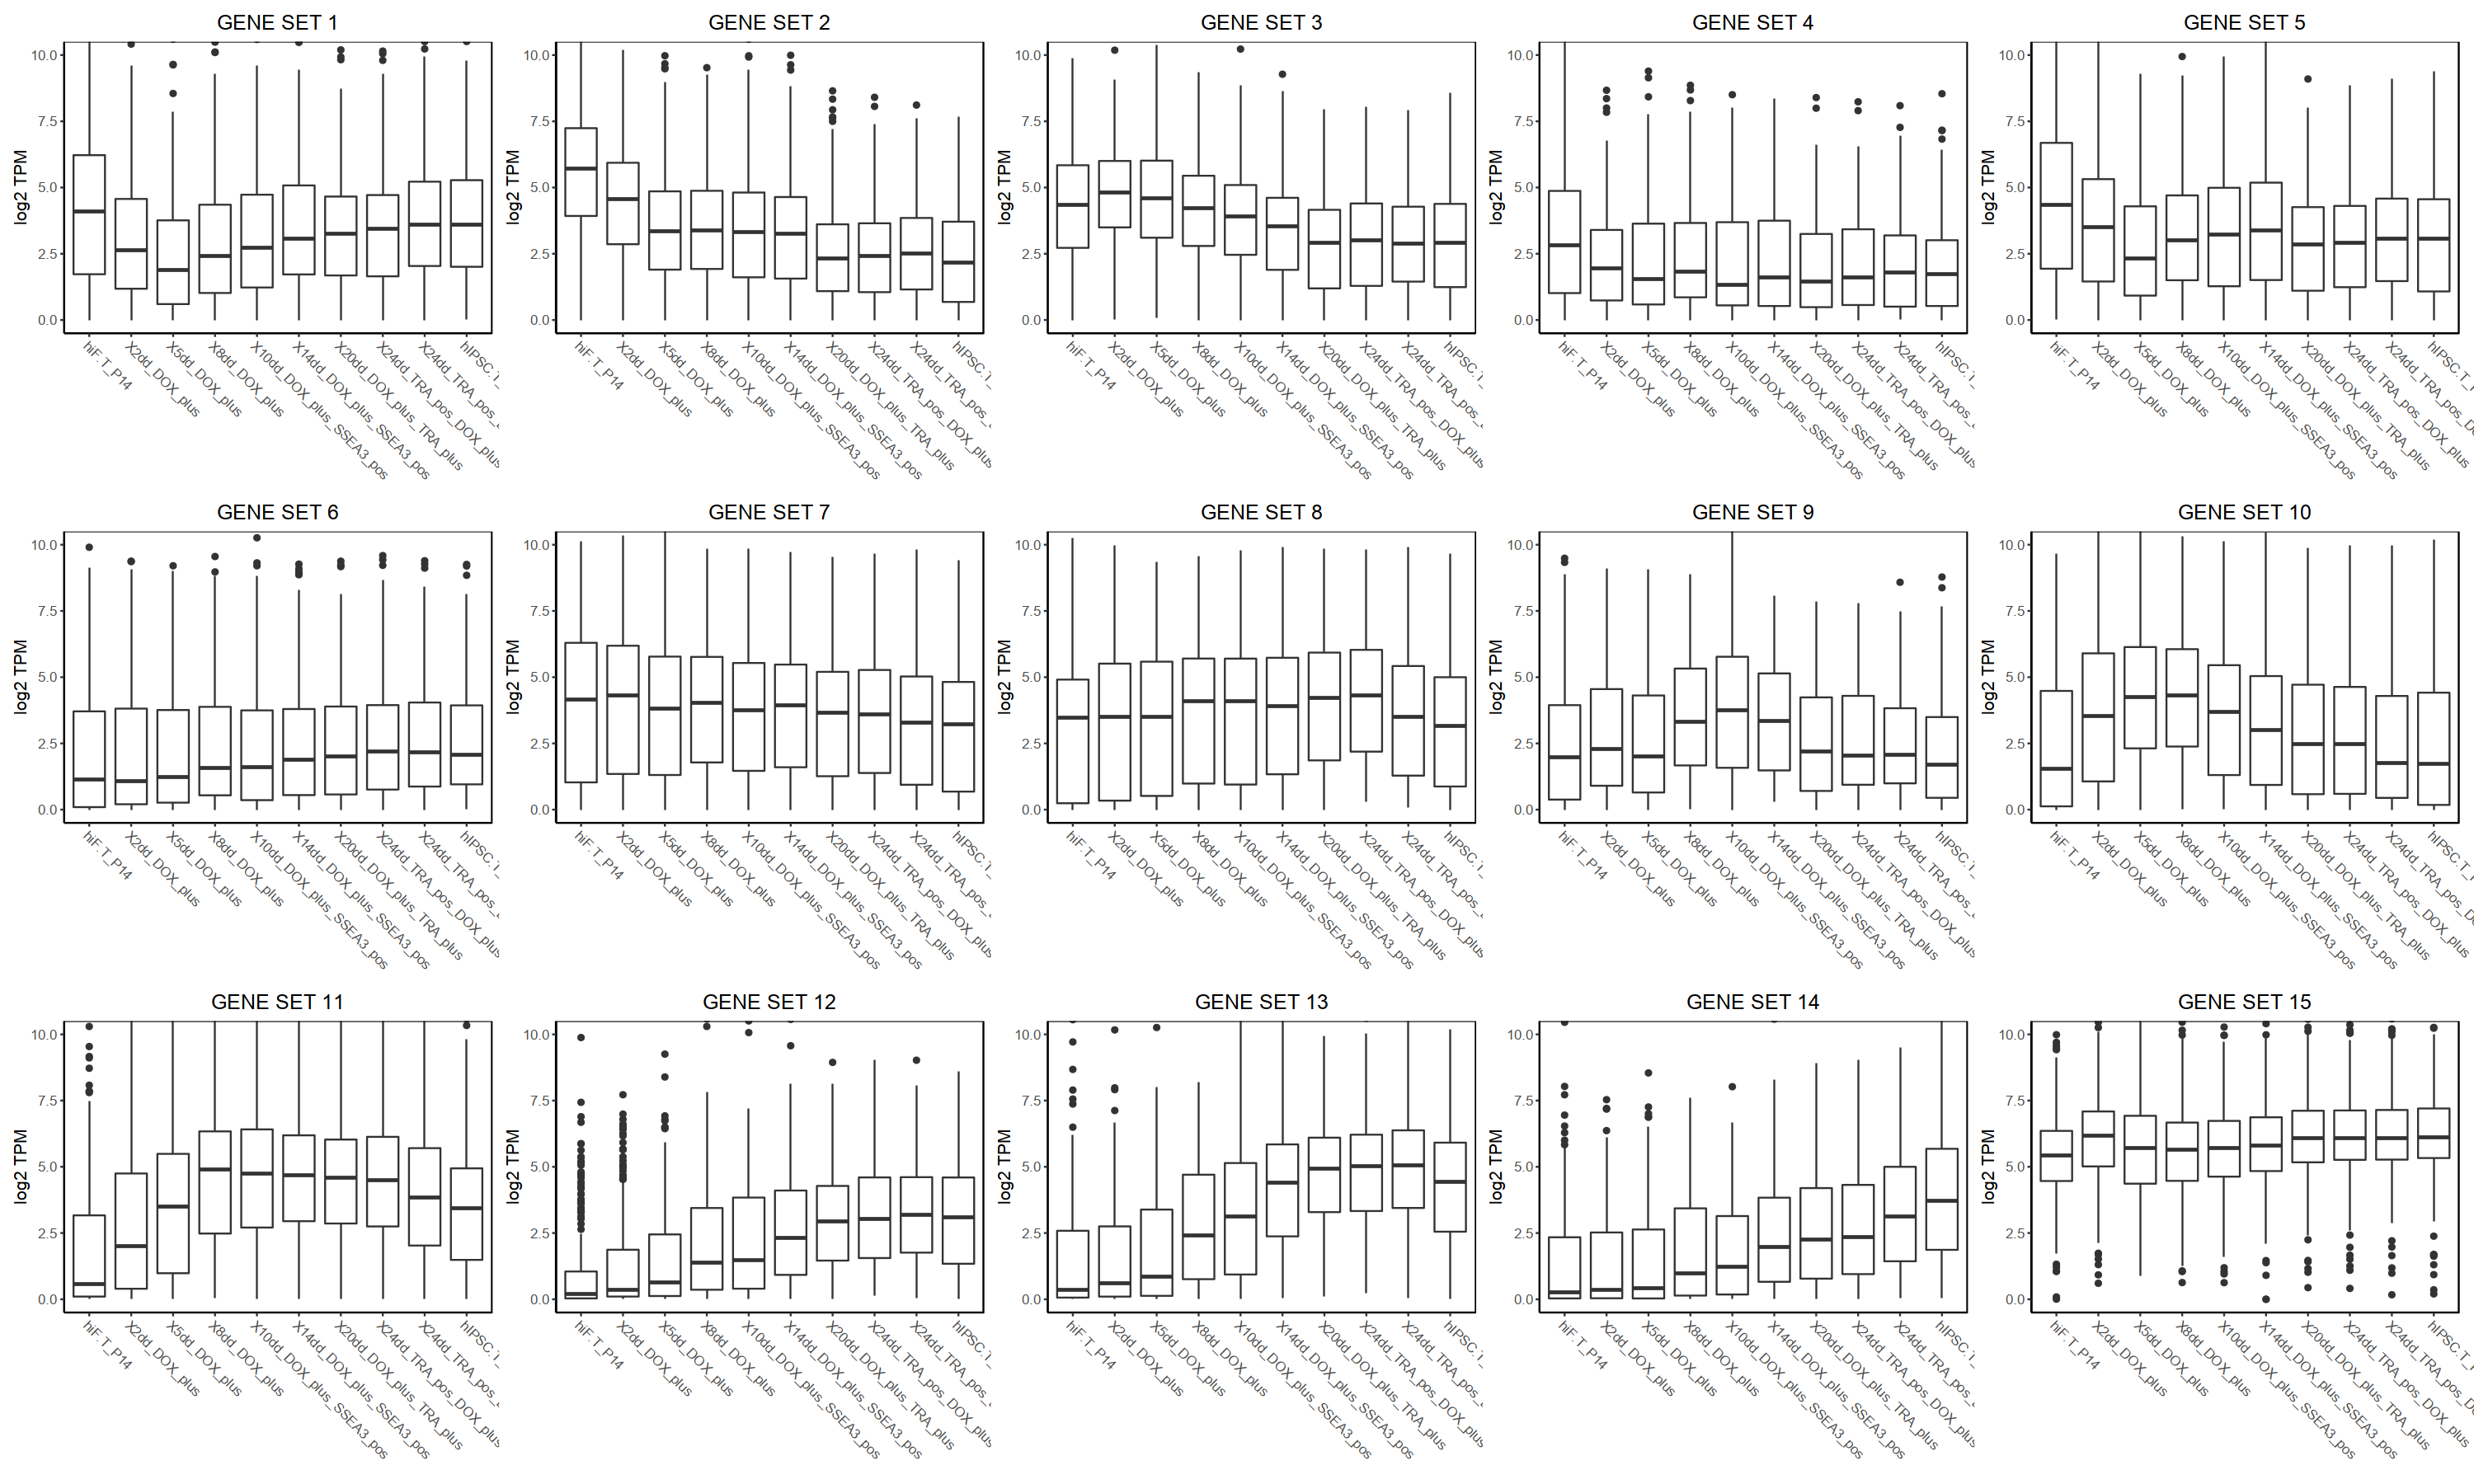

In [293]:
options(repr.plot.width = 25, repr.plot.height = 15)

wrap_plots(gene_plots, ncol = 5)

## g:Profiler

In [294]:
# assumes gene_table is sorted in decreasing importance
get_gprof_gost_res <- function(genes) {
    gostres = gost(genes, 
              organism="hsapiens",
              significant=F, # return all
              ordered_query=F)
    
    # compute enrichment (intersection/list_length)/(total_terms/total_genes)
    gostres$result$enrichment = (gostres$result$intersection_size/gostres$result$query_size)/(gostres$result$term_size/gostres$result$effective_domain_size)
    
    gostres
}

In [295]:
gprof_res = mclapply(gene_lists,
                     get_gprof_gost_res,
                     mc.cores=15)

In [373]:
gprof_res[[1]]$meta$version

[1] "e104_eg51_p15_3922dba"

In [297]:
filtered = gprof_res[[10]]$result
filtered = filtered[filtered$significant==TRUE, ]
filtered = filtered[filtered$source=="GO:BP", c(4,5,6,12, 10,11,3, 15)]
dim(filtered)
head(filtered[(order(filtered$p_value)), ], 5)

[1] 16  8

term_size query_size intersection_size effective_domain_size source
122 1446      246         46               18123                 GO:BP 
123 2816      246         71               18123                 GO:BP 
124 4116      246         90               18123                 GO:BP 
125 6164      246        121               18123                 GO:BP 
126  538      246         23               18123                 GO:BP 
    term_name                          p_value      enrichment
122 lipid metabolic process            9.092867e-05 2.343606  
123 anatomical structure morphogenesis 1.494199e-04 1.857465  
124 regulation of biological quality   1.061448e-03 1.610876  
125 anatomical structure development   1.166012e-03 1.446165  
126 regulation of hormone levels       2.683338e-03 3.149492

In [341]:
# save all data
saveRDS(gprof_res, "./gprof_results/20211005_n59378/gprof.rds")

In [343]:
# save for each peak set
for (i in seq(length(gene_lists))) {
    filtered = gprof_res[[i]]$result
    filtered = filtered[filtered$significant==TRUE, ]
    filtered = filtered[order(filtered$p_value), ]
    filtered = filtered[, c(-14)] 
    
    write.table(filtered, sprintf("./gprof_results/20211005_n59378/per_gene_set/gene_set_%d.tsv", i),
                sep='\t', quote=F, row.names=F)
}

In [346]:
# save for each peak set
for (i in seq(length(gene_lists))) {    
    write.table(gene_lists[[i]], sprintf("./gprof_results/20211005_n59378/gene_sets/idx%d.tsv", i),
                sep='\t', quote=F, row.names=F, col.names=F)
}

## Enrichment Matrices

In [298]:
MAX_LOG10_PVAL = 3 # restrict max p-value for clustering
SIG_PVAL = -log10(0.01)

make_term_peak_set_matrix <- function(term_list, sources) {
    # term_x_peak matrix
   txp_matrix = matrix(0, length(term_list), length(gene_lists))
    row.names(txp_matrix) = term_list
    colnames(txp_matrix) = seq(1, length(gene_lists))
    
    for (i in seq(length(gene_lists))) { 
        filtered = gprof_res[[i]]$result
        filtered = filtered[as.character(paste(filtered$term_id, filtered$term_name, sep=':')) %in% term_list, ]
        filtered = filtered[as.character(filtered$source) %in% sources, ] # need source since some terms are duplicated
        rownames(filtered) = paste(filtered$term_id, filtered$term_name, sep=':')
        txp_matrix[,i] = -log10(filtered[rownames(txp_matrix), ]$p_value)
    }

    txp_matrix[is.na(txp_matrix)] = 0
    txp_matrix[txp_matrix>MAX_LOG10_PVAL] = MAX_LOG10_PVAL
    
    txp_matrix
}

make_melted_txp_matrix <- function(txp_matrix, peak_set_order) {
    # reorder terms, but specify peak order
    term_order = hclust(dist(txp_matrix, method = "euclidean"), method = "ward.D")$order

    txp_matrix_melted = melt(txp_matrix)
    txp_matrix_melted$symbol = ifelse(txp_matrix_melted$value>= SIG_PVAL, "*", "")

    txp_matrix_melted$Var2 = factor(txp_matrix_melted$Var2, 
                                     levels=peak_set_order)
    txp_matrix_melted$Var1 = factor(txp_matrix_melted$Var1, 
                                     levels=levels(txp_matrix_melted$Var1)[term_order])

    txp_matrix_melted
}

plot_melted_txp_matrix <- function(txp_matrix_melted) {
    plot <- ggplot(txp_matrix_melted) +
    geom_tile(aes(x=Var2, 
                  y=Var1, 
                  fill= value),
             colour="black",
             size=0.5) +
    scale_fill_gradient(low="white",
                          high="red",
                          limits=c(0,3),
                          oob=squish,
                          name="- Log P-value") +
    geom_text(aes(x=Var2, y=Var1, label=symbol), vjust = 0.75) + 
    scale_y_discrete(position = "right") +
    ylab("") + xlab("") +
    theme_classic() +
    theme(plot.title = element_text(hjust = 0.5),
      text = element_text(size=15),
#       axis.text.x = element_text(angle = 45, hjust=0.5, vjust=.5),
      legend.title=element_text(size=10), 
      legend.text=element_text(size=9),
      axis.ticks.y=element_blank(),
      panel.border = element_rect(colour = "black", fill=NA, size=2),
      legend.position = "left") + 
     guides(x = guide_axis(angle = 45))
    
    plot
}

### GO:BP Matrix

In [350]:
# make a list of GO terms using cutoffs

ENRICH_CUTOFF = 2
TERM_SIZE_MAX = 5000
TERM_SIZE_MIN = 5
INTERSECT_SIZE_MIN = 2
TOP_BY_PVAL = 10 # add top K by pval per peak set
TOP_BY_ENRICH = 10 # add top K by enrichment per peak set
PVAL_CUTOFF = 0.01
gobp_terms = c()

for (i in seq(length(gene_lists))) {
    filtered = gprof_res[[i]]$result
    filtered = filtered[filtered$significant==TRUE, ]
    filtered = filtered[filtered$source=="GO:BP", c(4,5,6,12, 9,10,11,3, 15)]
    filtered = filtered[filtered$enrichment>ENRICH_CUTOFF, ]
    filtered = filtered[filtered$p_value<PVAL_CUTOFF, ]
    filtered = filtered[filtered$term_size<TERM_SIZE_MAX, ]
    filtered = filtered[filtered$term_size>=TERM_SIZE_MIN, ]
    filtered = filtered[filtered$intersection_size>=INTERSECT_SIZE_MIN, ]
    filtered = filtered[unique(order(filtered$p_value)[1:TOP_BY_PVAL],
                              rev(order(filtered$enrichment))[1:TOP_BY_ENRICH]), ]
    
    gobp_terms = unique(c(gobp_terms, paste(filtered$term_id, filtered$term_name, sep=':')))
}

# gobp_terms = names(table(gobp_terms)[table(gobp_terms)<=MAX_APPEARANCES])
gobp_terms = gobp_terms[gobp_terms!="NA:NA"]
length(gobp_terms)

[1] 85

In [351]:
gobp_terms[grep("stem", gobp_terms)]
gobp_terms[grep("pluri", gobp_terms)]
gobp_terms[grep("fibro", gobp_terms)]
gobp_terms[grep("apop", gobp_terms)]
gobp_terms[grep("water", gobp_terms)]
gobp_terms[grep("adhesion", gobp_terms)]
gobp_terms[grep("metal", gobp_terms)]

[1] "GO:0072359:circulatory system development"          
[2] "GO:0001501:skeletal system development"             
[3] "GO:0035019:somatic stem cell population maintenance"
[4] "GO:0019827:stem cell population maintenance"        
[5] "GO:0007399:nervous system development"              
[6] "GO:0007417:central nervous system development"

character(0)

character(0)

[1] "GO:0033032:regulation of myeloid cell apoptotic process"
[2] "GO:0033028:myeloid cell apoptotic process"

character(0)

[1] "GO:0007155:cell adhesion"                                   
[2] "GO:0022610:biological adhesion"                             
[3] "GO:0098609:cell-cell adhesion"                              
[4] "GO:0086042:cardiac muscle cell-cardiac muscle cell adhesion"

character(0)

In [352]:
gobp_matrix = make_term_peak_set_matrix(gobp_terms, sources=c("GO:BP"))
# GENE_SET_ORDER = rev(hclust(dist(t(gobp_matrix), method = "euclidean"), method = "ward.D")$order) # use for REAC plot also
GENE_SET_ORDER = seq(1, ncol(gobp_matrix)) # no reorder
gobp_matrix_melted = make_melted_txp_matrix(gobp_matrix, GENE_SET_ORDER)

In [353]:
head(melt(gobp_matrix))

Var1                                                  Var2 value
1 GO:0070887:cellular response to chemical stimulus     1    3    
2 GO:0009653:anatomical structure morphogenesis         1    3    
3 GO:0010648:negative regulation of cell communication  1    3    
4 GO:0023057:negative regulation of signaling           1    3    
5 GO:0072359:circulatory system development             1    3    
6 GO:0009968:negative regulation of signal transduction 1    3

In [354]:
# remove idx from peak set 
# gobp_matrix_melted$Var2 = factor(sub("idx", "", gobp_matrix_melted$Var2),
#                                  sub("idx", "", levels(gobp_matrix_melted$Var2)))

In [355]:
gobp_plot = plot_melted_txp_matrix(gobp_matrix_melted)

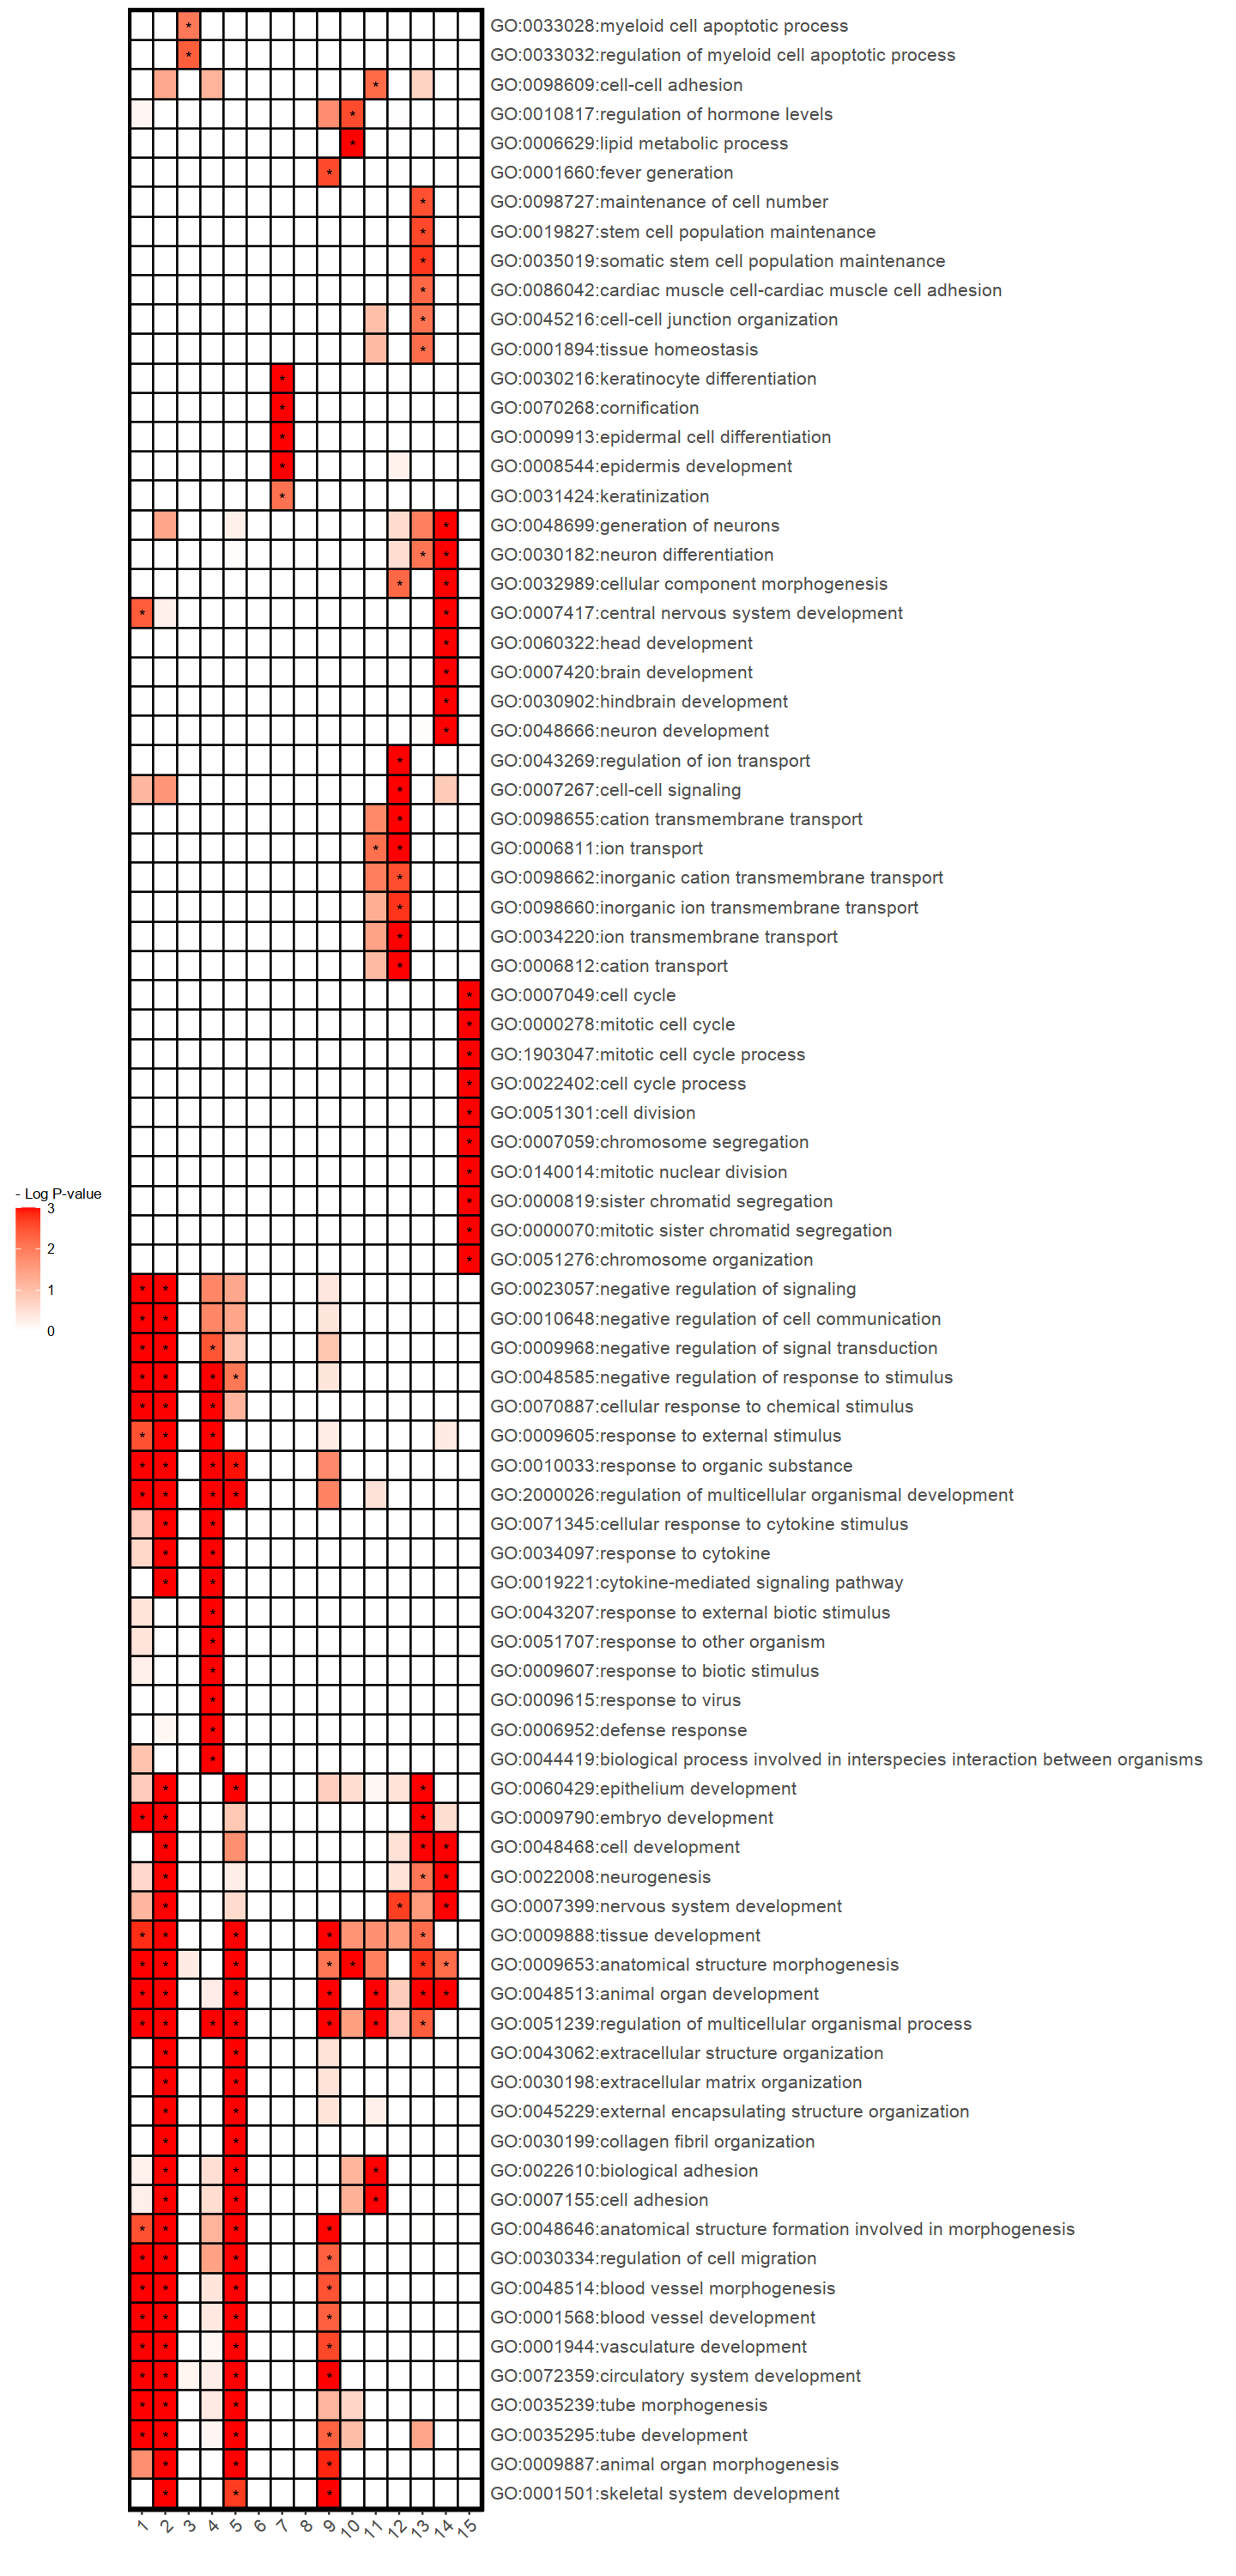

In [356]:
options(repr.plot.width = 12, repr.plot.height = 25)

gobp_plot

In [358]:
ggsave(sprintf("../../figures_factory/Fig2/subfigs/%s_gene_set_GOBP_grid_ENRICH_%.3f_TERM_SIZE_MIN_%d_MAX_%d_INTERSECT_SIZE_MIN_%d_TOP_BY_PVAL_%d_ENRICH_%d_PVAL_CUTOFF_%.3f.pdf",
               format(Sys.Date(), "%Y%m%d"),
              ENRICH_CUTOFF, 
               TERM_SIZE_MIN,
              TERM_SIZE_MAX, INTERSECT_SIZE_MIN, TOP_BY_PVAL, TOP_BY_ENRICH, PVAL_CUTOFF), height=25, width=12)

In [306]:
# saveRDS(gobp_plot, file=sprintf("./subfigs/%s_go_terms.rds",
#                                 format(Sys.Date(), "%Y%m%d")))

### REAC Matrix

In [364]:
# make a list of REAC terms using cutoffs

ENRICH_CUTOFF = 1.5
TERM_SIZE_MAX = 5000
TERM_SIZE_MIN = 1
TOP_BY_PVAL = 10 # add top K by pval per peak set
TOP_BY_ENRICH = 10 # add top K by enrichment per peak set
PVAL_CUTOFF = 0.01
reac_terms = c()

for (i in seq(length(gene_lists))) {
    filtered = gprof_res[[i]]$result
    filtered = filtered[filtered$significant==TRUE, ]
    filtered = filtered[filtered$source=="REAC", c(4,5,6,12, 9, 10,11,3, 15)]
    filtered = filtered[filtered$enrichment>ENRICH_CUTOFF, ]
    filtered = filtered[filtered$p_value<PVAL_CUTOFF, ]
    filtered = filtered[filtered$term_size<TERM_SIZE_MAX, ]
    filtered = filtered[filtered$term_size>=TERM_SIZE_MIN, ]
    filtered = filtered[unique(order(filtered$p_value)[1:TOP_BY_PVAL],
                              rev(order(filtered$enrichment))[1:TOP_BY_ENRICH]), ]
    
    reac_terms = unique(c(reac_terms, paste(filtered$term_id, filtered$term_name, sep=':')))
}

reac_terms = reac_terms[reac_terms!="NA:NA"]
length(reac_terms)

[1] 41

In [365]:
reac_terms[grep("pluri", reac_terms)]
reac_terms[grep("fibro", reac_terms)]
reac_terms[grep("OAS", reac_terms)]
reac_terms[grep("stem", reac_terms)]

[1] "REAC:R-HSA-452723:Transcriptional regulation of pluripotent stem cells"

character(0)

[1] "REAC:R-HSA-8983711:OAS antiviral response"

[1] "REAC:R-HSA-1280215:Cytokine Signaling in Immune system"                
[2] "REAC:R-HSA-168256:Immune System"                                       
[3] "REAC:R-HSA-452723:Transcriptional regulation of pluripotent stem cells"

In [366]:
reac_matrix = make_term_peak_set_matrix(reac_terms, sources=c("REAC"))
reac_matrix_melted = make_melted_txp_matrix(reac_matrix, GENE_SET_ORDER)
reac_plot = plot_melted_txp_matrix(reac_matrix_melted)

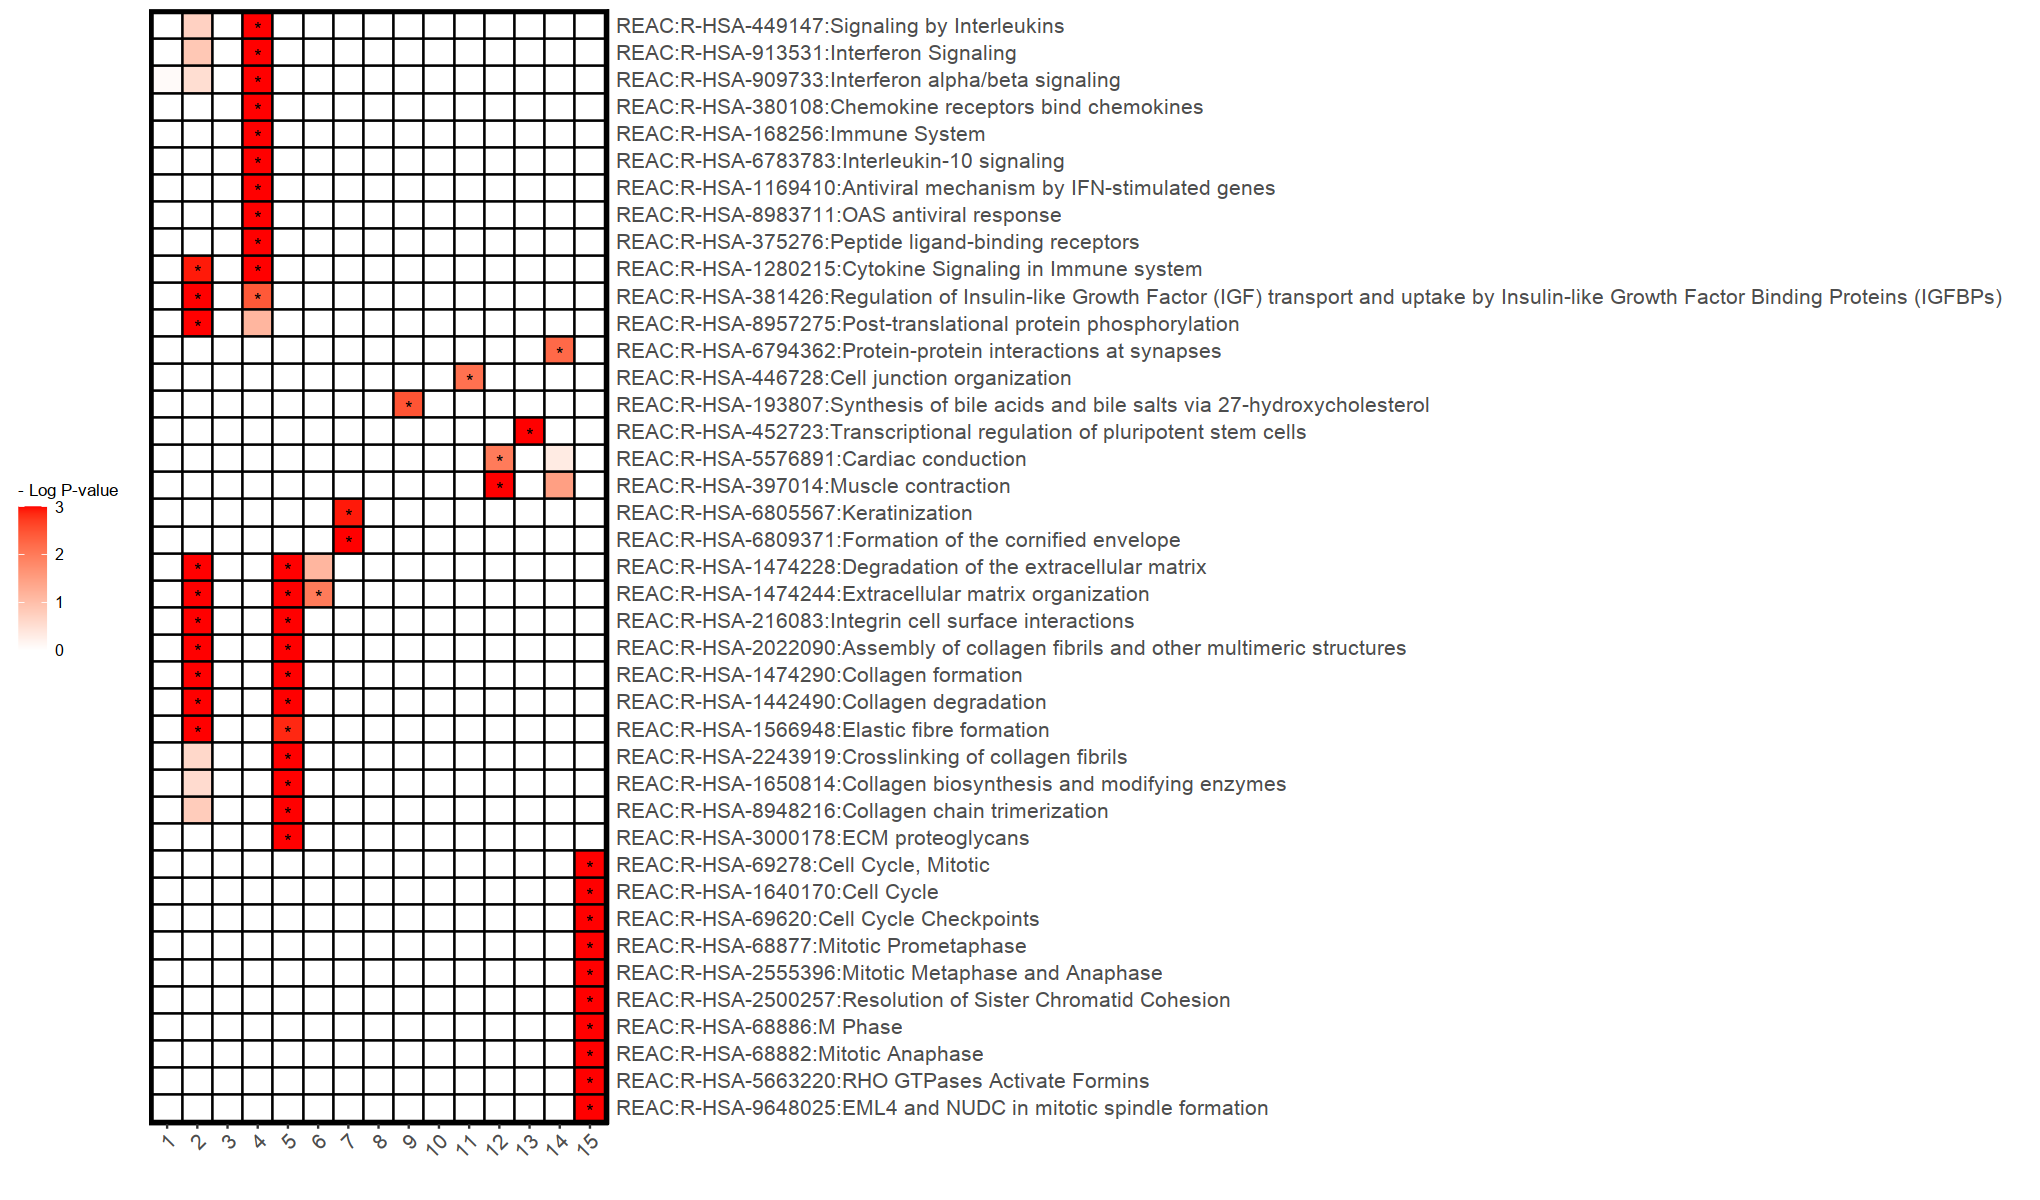

In [369]:
options(repr.plot.width = 17, repr.plot.height = 10)

reac_plot

In [370]:
ggsave(sprintf("../../figures_factory/Fig2/subfigs/%s_gene_set_REAC_grid_ENRICH_%.3f_TERM_SIZE_MIN_%d_MAX_%d_INTERSECT_SIZE_MIN_%d_TOP_BY_PVAL_%d_ENRICH_%d_PVAL_CUTOFF_%.3f.pdf",
               format(Sys.Date(), "%Y%m%d"),
              ENRICH_CUTOFF, 
               TERM_SIZE_MIN,
              TERM_SIZE_MAX, INTERSECT_SIZE_MIN, TOP_BY_PVAL, TOP_BY_ENRICH, PVAL_CUTOFF), height=10, width=17)

---

In [371]:
sessionInfo()

R version 3.6.3 (2020-02-29)
Platform: x86_64-conda_cos6-linux-gnu (64-bit)
Running under: Ubuntu 18.04.5 LTS

Matrix products: default
BLAS/LAPACK: /users/surag/anaconda3/envs/r36_cran/lib/libopenblasp-r0.3.9.so

locale:
 [1] LC_CTYPE=en_US.UTF-8       LC_NUMERIC=C              
 [3] LC_TIME=en_US.UTF-8        LC_COLLATE=en_US.UTF-8    
 [5] LC_MONETARY=en_US.UTF-8    LC_MESSAGES=en_US.UTF-8   
 [7] LC_PAPER=en_US.UTF-8       LC_NAME=C                 
 [9] LC_ADDRESS=C               LC_TELEPHONE=C            
[11] LC_MEASUREMENT=en_US.UTF-8 LC_IDENTIFICATION=C       

attached base packages:
[1] parallel  stats4    stats     graphics  grDevices utils     datasets 
[8] methods   base     

other attached packages:
 [1] scattermore_0.7             gprofiler2_0.1.9           
 [3] reshape2_1.4.4              scales_1.1.0               
 [5] ClusterR_1.2.2              gtools_3.8.2               
 [7] DESeq2_1.26.0               SummarizedExperiment_1.16.1
 [9] DelayedArray_0.12.3       